In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nb
import random

In [2]:
mri_file = glob('*')[2]
mri_im = nb.load(mri_file)
# mri_hdr = mri_im.header
mri_data = mri_im.get_fdata()

In [3]:
sos_file = glob('*')[3]
sos_im = nb.load(sos_file)
# sos_hdr = sos_im.header
sos_data = sos_im.get_fdata()

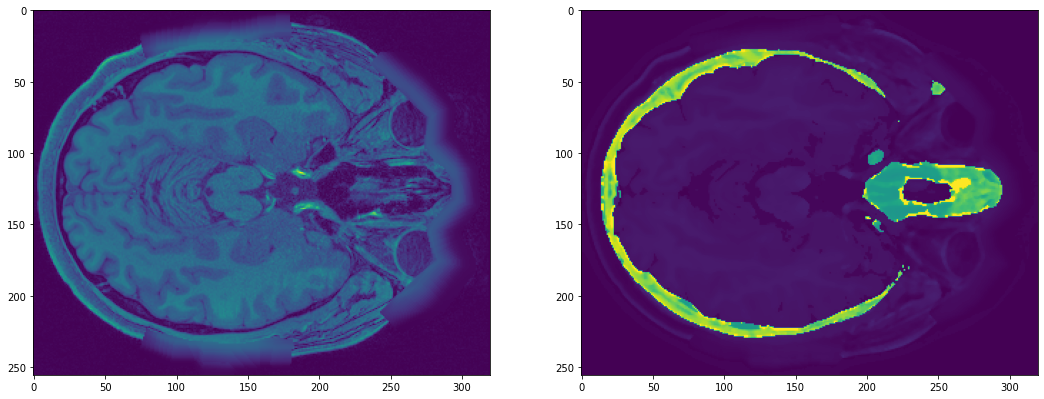

In [4]:
f = plt.subplots(1,2,figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(mri_data[:,:,120])
plt.subplot(1,2,2)
plt.imshow(sos_data[:,:,120])

In [5]:
np.array(mri_data[:,:,120])

array([[30.63180542, 19.13003159, 36.94176483, ..., 34.09760666,
        52.213974  ,  0.        ],
       [28.03886414, 70.04286957,  6.36014652, ...,  8.52085304,
        27.69382858,  0.        ],
       [11.44579697, 25.41544342,  8.88510513, ..., 45.77104568,
        35.1279335 ,  0.        ],
       ...,
       [27.92882729, 55.82710266, 53.45714569, ..., 76.03562927,
        74.92530823,  0.        ],
       [43.08220673, 34.91239548, 10.46512985, ..., 36.90913773,
        36.91300964,  0.        ],
       [18.63014412, 79.13476562, 22.09305191, ..., 71.58135986,
        50.33592606,  0.        ]])

In [4]:
# take just one slice nad make it a 1d vector
mri_slice = np.array(mri_data[:,:,120]).flatten()
mri_slice = pd.Series(mri_slice)
sos_slice = np.array(sos_data[:,:,120]).flatten()
sos_slice = pd.Series(sos_slice)

Wall time: 5.75 s


Text(0, 0.5, 'sound speed')

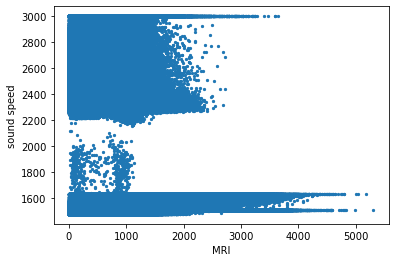

In [36]:
%%time
plt.scatter(mri_data, sos_data, s=5)
plt.xlabel("MRI")
plt.ylabel("sound speed")

In [5]:
# let's examine how much of the data comes from the skull
skull = []
for i in range(len(sos_slice)):
    if sos_slice[i] >= 1700:
        skull.append(i)

print(str(len(skull)) + ' out of ' + str(len(sos_slice)) + ' pixels were bone.')
print('Thats ' + str(len(skull)*100/len(sos_slice)) + ' percent.')

6635 out of 81920 pixels were bone.
Thats 8.099365234375 percent.


In [6]:
# replace any values over 1700 by 0s
soft_sos = pd.Series([])
soft_mri = pd.Series([])
for i in range(len(sos_slice)):
    if sos_slice[i] >= 1700:
        soft_sos = soft_sos.append(pd.Series(0))
        soft_mri = soft_mri.append(pd.Series(0))
    elif sos_slice[i] < 1700:
        soft_sos = soft_sos.append(pd.Series(sos_slice[i]))
        soft_mri = soft_mri.append(pd.Series(mri_slice[i]))

/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_18988/3531554605.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  soft_sos = pd.Series([])
/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_18988/3531554605.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  soft_mri = pd.Series([])


In [79]:
soft_mri

0    30.631805
0    19.130032
0    36.941765
0    61.050480
0    25.388670
       ...    
0     7.825107
0    53.674763
0    71.581360
0    50.335926
0     0.000000
Length: 81920, dtype: float64

Text(0.5, 1.0, 'MRI')

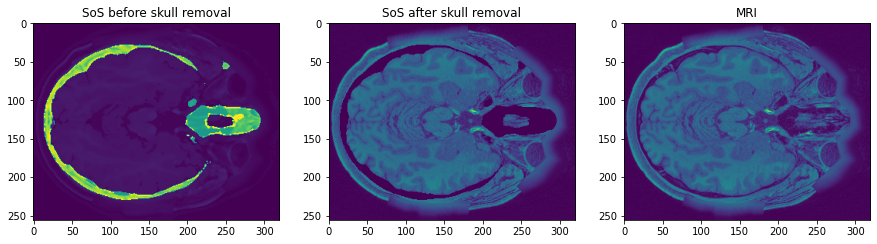

In [9]:
# just out of curiosity, let's replot the SoS graph without the skull
# first reshape the data
soft_sos_2 = soft_mri.copy()
soft_sos_2 = np.array(soft_sos_2).reshape([256, 320])
f = plt.subplots(1,3,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(sos_data[:,:,120])
plt.title('SoS before skull removal')
plt.subplot(1,3,2)
plt.imshow(soft_sos_2)
plt.title('SoS after skull removal')
plt.subplot(1,3,3)
plt.imshow(mri_data[:,:,120])
plt.title('MRI')

(1400.0, 1700.0)

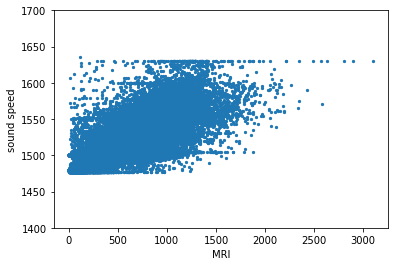

In [10]:
plt.scatter(soft_mri, soft_sos, s=5)
plt.xlabel("MRI")
plt.ylabel("sound speed")
plt.ylim(bottom=1400, top=1700)

In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(soft_mri, soft_sos, test_size=0.33, random_state=42)

In [7]:
# lets do 70% train, 30% test
train_X = pd.DataFrame()
train_y = pd.DataFrame()
train_indices = []
for i in range(int(0.7*soft_mri.shape[0])):
    # get 70% of the set for training from the whole thing randomly
    r = random.randint(0, soft_mri.shape[0]-1) 
    train_indices.append(r)
    train_X = train_X.append(pd.Series(soft_mri.iloc[r]), ignore_index=True)
    train_y = train_y.append(pd.Series(soft_sos.iloc[r]), ignore_index=True)
print(train_X.shape)

(57344, 1)


In [24]:
test_X = pd.DataFrame()
test_y = pd.DataFrame()
test_indices = []
while test_y.shape[0] < 0.30*soft_mri.shape[0]:
    r = random.randint(0, soft_mri.shape[0]-1)

    if(r not in train_indices): 
        test_indices.append(r)
        test_X = test_X.append(pd.Series(soft_mri.iloc[r]), ignore_index=True)
        test_y = test_y.append(pd.Series(soft_sos.iloc[r]), ignore_index=True)
print("Number of test images: " + str(soft_mri.shape[0]))


Number of test images: 81920


In [25]:
train_X = np.array(train_X).reshape(-1,1)
train_y = np.array(train_y).reshape(-1,1)
test_X = np.array(test_X).reshape(-1,1)
test_y = np.array(test_y).reshape(-1,1)
print(test_X.shape)

(24576, 1)


In [26]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(train_X, train_y)

LinearRegression()

In [27]:
preds = linear.predict(test_X)

In [28]:
coef = linear.coef_
intercept = linear.intercept_
print("The coefficient is " + str(coef[0][0]))
print("The intercept is " + str(intercept[0]))

The coefficient is 0.38916925513316686
The intercept is 1190.0162564780244


In [29]:
r2 = linear.score(test_y, preds)
print('The R2 score is ' + str(r2))

The R2 score is -3.4728157244208004


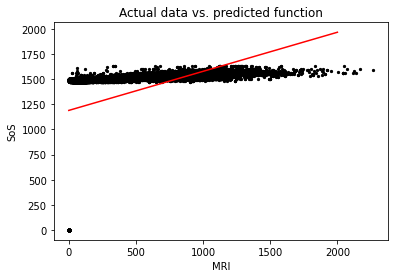

In [30]:
x = np.linspace(0,2000)
y = coef * x + intercept

plt.figure()
plt.scatter(test_X, test_y, c='black', s=5)
# plt.ylim(bottom=1400, top=1700)
plt.plot(x, y[0], '-r')
plt.title("Actual data vs. predicted function")
plt.xlabel("MRI")
plt.ylabel("SoS")
plt.show()

In [31]:
# the linear regression might be off because of the many 0s we have. Let's take them away
soft_sos_2 = soft_sos[soft_sos!=0]
soft_mri_2 = soft_mri[soft_sos!=0]

if (len(soft_sos_2) == 75285): print("0s eliminated correctly.")
else: print("Something went wrong. You have "+str(len(soft_sos_2))+" values, and you should have 75285 values.")

0s eliminated correctly.


In [32]:
# lets do 70% train, 30% test
train_X_2 = pd.DataFrame()
train_y_2 = pd.DataFrame()
train_indices = []
for i in range(int(0.7*soft_mri_2.shape[0])):
    # get 70% of the set for training from the whole thing randomly
    r = random.randint(0, soft_mri_2.shape[0]-1) 
    train_indices.append(r)
    train_X_2 = train_X_2.append(pd.Series(soft_mri_2.iloc[r]), ignore_index=True)
    train_y_2 = train_y_2.append(pd.Series(soft_sos_2.iloc[r]), ignore_index=True)
print(train_X_2.shape)

(52699, 1)


In [35]:
test_X_2 = pd.DataFrame()
test_y_2 = pd.DataFrame()
test_indices = []
while test_y_2.shape[0] < 0.30*soft_sos_2.shape[0]:
    r = random.randint(0, soft_mri_2.shape[0]-1)
    if(r not in train_indices): 
        test_indices.append(r)
        test_X_2 = test_X_2.append(pd.Series(soft_mri_2.iloc[r]), ignore_index=True)
        test_y_2 = test_y_2.append(pd.Series(soft_sos_2.iloc[r]), ignore_index=True)
print("Number of test images: " + str(test_X_2.shape[0]))


Number of test images: 22586


In [36]:
train_X_2 = np.array(train_X_2).reshape(-1,1)
train_y_2 = np.array(train_y_2).reshape(-1,1)
test_X_2 = np.array(test_X_2).reshape(-1,1)
test_y_2 = np.array(test_y_2).reshape(-1,1)

In [37]:
from sklearn.linear_model import LinearRegression
linear_2 = LinearRegression()
linear_2.fit(train_X_2, train_y_2)

LinearRegression()

In [38]:
preds_2 = linear_2.predict(test_X_2)
coef_2 = linear_2.coef_
intercept_2 = linear_2.intercept_
print("The coefficient is " + str(coef_2[0][0]))
print("The intercept is " + str(intercept_2[0]))

The coefficient is 0.0752194194041168
The intercept is 1481.8913746916442


In [39]:
r2_2 = linear_2.score(test_y_2, preds_2)
print('The R2 score is ' + str(r2_2))

The R2 score is -4.222080901469376


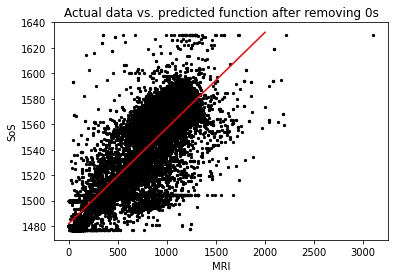

In [40]:
x_2 = np.linspace(0,2000)
y_2 = coef_2 * x_2 + intercept_2

plt.figure()
plt.scatter(test_X_2, test_y_2, c='black', s=5)
# plt.ylim(bottom=1400, top=1700)
plt.plot(x_2, y_2[0], '-r')
plt.title("Actual data vs. predicted function after removing 0s")
plt.xlabel("MRI")
plt.ylabel("SoS")
plt.show()